In [4]:
import torch
from torch import nn
from torchvision import transforms as T

import time, datetime
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# change directory
import os
# os.chdir('/kaggle/input/gym-super-mario-bros')

# install controller
!pip --disable-pip-version-check install -q nes_py
from nes_py.wrappers import JoypadSpace

import gym_super_mario_bros

In [5]:
# Install basic dependencies.
%pip install gym-super-mario-bros nes-py matplotlib opencv-python
# Install dependencies for RL.
%pip install stable-baselines3
# Install PyTorch (customized).
%pip install torch torchvision torchaudio tensorboard

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import the game.
import gym_super_mario_bros
# Import the Joypad wrapper.
from nes_py.wrappers import JoypadSpace
# Import the simplified controls.
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

ModuleNotFoundError: No module named 'gym_super_mario_bros'

### Preprocessing environment

In [ ]:
# Import GrayScaling Wrapper.
from gym.wrappers import GrayScaleObservation
# Import Vectorization wrappers.
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking.
from matplotlib import pyplot as plt

In [8]:
class SkipFrame(gym.Wrapper):
    '''
        Custom wrapper that inherits from gy.Wrapper and implements the step() function.
        Use it to return only every skip nth frame
    '''
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip
        
    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [9]:
class GrayScaleObservation(gym.ObservationWrapper):
    '''
        Common wrapper to transform an RGB image to grayscale; doing so reduces the size of the state representation without losing useful information.
        Now the size of each state: [1, 240, 256]
    '''
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
        self.transform = T.Grayscale()
    
    def permute_orientation(self, observation):
        observation = np.transpose(observation, (2, 0, 1))
        return torch.tensor(observation.copy(), dtype=torch.float)
    
    def observation(self, observation):
        observation = self.permute_orientation(observation)
        return self.transform(observation)

In [10]:
class ResizeObservation(gym.ObservationWrapper):
    '''
        Downsamples each observation into a square image.
        New size: [1, 84, 84]
    '''
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int): self.shape = (shape, shape)
        else: self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
        
    def observation(self, observation):
        transforms = T.Compose([T.Resize(self.shape), T.Normalize(0, 255)])
        return transforms(observation).squeeze(0)

In [12]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')

env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

In [24]:
# Create base environment.
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplify the controls.
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale environment.
env = GrayScaleObservation(env, keep_dim=True)
# Wrap inside dummy environment.
env = DummyVecEnv([lambda: env])
# Stack frames.
env = VecFrameStack(env, 4)

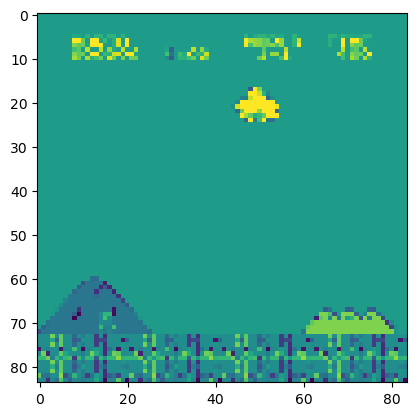

In [13]:
# Use Matplotlib to show a game frame.
state = env.reset()
state.shape
plt.imshow(state[0])

In [15]:
# Fill out frame stack.
for _ in range(20):
    state, reward, done, info = env.step([5])

# Use Matplotlib to show a visualization of the frame stack.
plt.figure(figsize=(2000, 1600))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx+1)
    plt.imshow(state[0][:, :, idx])

plt.show()

# Reset environment.
state = env.reset()

IndexError: tuple index out of range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f148bd2bf80> (for post_execute):


ValueError: Image size of 200000x160000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 200000x160000 with 0 Axes>

### Train RL model

In [16]:
# Import os for file path management.
import os
# Import PPO for algos.
from stable_baselines3 import PPO
# Import BaseCallback for saving models.
from stable_baselines3.common.callbacks import BaseCallback

In [17]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
#     def __init__(self, env_freq=1000):
#         super(RenderCallback, self).__init__()
#         self.env_freq = env_freq

#     def _on_step(self):
#         if self.num_timesteps % self.env_freq == 0:
#             self.model.env.render()

        return True

In [18]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [19]:
# env.render()

In [ ]:
class RenderCallback(BaseCallback):
    def __init__(self, env_freq=1000):
        super(RenderCallback, self).__init__()
        self.env_freq = env_freq

    def _on_step(self):
        if self.num_timesteps % self.env_freq == 0:
            self.model.env.render()

In [20]:
# Setup model saving callback.
from stable_baselines3.common.callbacks import BaseCallback
# callback = RenderCallback()
callback = TrainAndLoggingCallback(check_freq=5_000, save_path=CHECKPOINT_DIR)

In [21]:
# Start AI model.
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.00000001, n_steps=512)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
# Train the AI model, the AI model starts to learn.
model.learn(total_timesteps=5_000, callback=callback)

Logging to ./logs/PPO_3
----------------------------
| time/              |     |
|    fps             | 49  |
|    iterations      | 1   |
|    time_elapsed    | 10  |
|    total_timesteps | 512 |
----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 60        |
|    iterations           | 2         |
|    time_elapsed         | 16        |
|    total_timesteps      | 1024      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.55     |
|    explained_variance   | 0         |
|    learning_rate        | 1e-08     |
|    loss                 | 233       |
|    n_updates            | 10        |
|    policy_gradient_loss | -3.71e-08 |
|    value_loss           | 527       |
---------------------------------------
---------------------------------------
| time/      

### Test

In [23]:
# /kaggle/working/train

In [24]:
!pip --disable-pip-version-check install -q pyvirtualdisplay

from pyvirtualdisplay import Display

from IPython import display as ipythondisplay
from IPython.display import HTML

from gym.wrappers import Monitor
from glob import glob

import base64
import io

display = Display(visible=0, size=(600, 300))
display.start()

In [25]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob('/kaggle/working/video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, '/kaggle/working/video', force=True)
    return env

env = wrap_env(env)

In [26]:
# Load last model.
model = PPO.load('/kaggle/working/train/best_model_5000.zip')

In [27]:
# Fresh start.
state = env.reset()

ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /opt/conda/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


In [28]:
# Loop through the game.
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()
    if done:
        break
    
env.close()
show_video()

AttributeError: 'LazyFrames' object has no attribute 'reshape'

In [ ]:
# Closes the game.
env.close()